In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")
include("spiking.jl")

train_to_phase (generic function with 2 methods)

In [16]:
model = Chain(PhasorDense(1024 => 256), )

Chain(
  PhasorDense(1024 => 256),             # 262_400 parameters
) 

In [17]:
x = random_symbols((100, 1024))

100×1024 Matrix{Float64}:
 -0.634145    0.0866134  -0.61242   …   0.987594   -0.73394     0.683795
 -0.0694872  -0.37002    -0.584692     -0.815346    0.275856   -0.539974
  0.623356   -0.59001     0.428521      0.101115    0.0234753   0.564104
  0.504999   -0.346533   -0.148208      0.909852   -0.0334074   0.928877
 -0.461677    0.266565   -0.452625      0.996979   -0.0441287  -0.894245
 -0.677392    0.821804    0.943948  …  -0.142063   -0.16134     0.237722
  0.027714   -0.205394    0.931874     -0.349563   -0.748165   -0.0780145
 -0.601901   -0.662482    0.950588     -0.543265    0.741126    0.382671
 -0.379675    0.153077   -0.862044      0.192536   -0.231046   -0.801223
 -0.148222    0.965188   -0.294742      0.147338   -0.564067   -0.352135
 -0.800721    0.627208   -0.784521  …  -0.408386   -0.728438   -0.331271
 -0.135238    0.774462    0.181888      0.975137    0.16576     0.241163
 -0.448212    0.855187    0.286276     -0.299974   -0.730744   -0.922415
  ⋮                     

In [18]:
x |> size

(100, 1024)

In [19]:
y = model(x)

100×256 Matrix{Float64}:
 -0.137416    -0.0114964  -0.0202662  …  -0.273477    -0.119257
  0.020353     0.34639    -0.926839      -0.0927099    0.125108
 -0.755079    -0.177812   -0.257734       0.146577     0.452643
 -0.218215    -0.186112    0.222412       0.283336     0.118096
 -0.163757    -0.570742   -0.345578       0.165239     0.292992
  0.0533794   -0.0488632  -0.192163   …   0.189821    -0.187051
 -0.00277059  -0.285457    0.314056       0.159466     0.318448
  0.0729547   -0.440255   -0.0160014     -0.511144    -0.0609113
  0.0210996   -0.299523   -0.19229        0.00975114  -0.311401
  0.115972    -0.607035   -0.56347        0.130503    -0.303572
 -0.4235       0.160161   -0.180275   …   0.0320072   -0.236546
  0.219331     0.119241    0.37125       -0.196906     0.142677
 -0.216039     0.213799    0.540407      -0.00772965  -0.145491
  ⋮                                   ⋱                ⋮
  0.388902    -0.360289    0.205022      -0.0937753    0.000224692
 -0.106308    -0.2

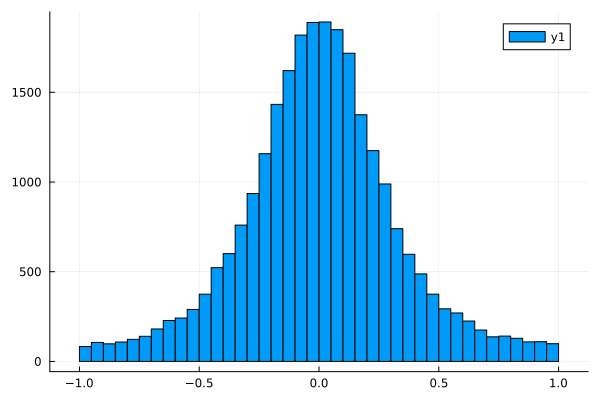

In [20]:
histogram(y |> vec)

In [21]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [22]:
xt = phase_to_train(x, sa, repeats = 5)

Spike Train: (100, 1024) with 512000 spikes.

In [23]:
call = SpikingCall(xt, sa, (0.0, 10.0))

SpikingCall(Spike Train: (100, 1024) with 512000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [24]:
model[1].weight

256×1024 Matrix{Float32}:
 -0.0150155   -0.045255     0.0311358   …  -0.0652349    0.0272839
 -0.00253256   0.0490234   -0.00799301      0.0449326    0.0666099
 -0.0168257   -0.0192345    0.0556465      -0.0437034   -0.0597727
  0.0324886    0.0472137    0.0212682       0.00178783  -0.0608578
 -0.0140311   -0.0147198    0.0392608      -0.0401595    0.0589383
 -0.00175601   0.0365958    0.0607711   …   0.00405628  -0.0200594
 -0.013985    -0.0635792   -0.0653193      -0.0597948    0.0609105
 -0.00369954   0.0429233   -0.0521984       0.0222139   -0.0502626
 -0.0386143   -0.0241395   -0.00115068      0.0177626    0.0250918
 -0.0599088    0.0169496   -0.0622204       0.0321221    0.0256363
 -0.012832    -0.00286623   0.0277645   …  -0.0143793   -0.0670895
 -0.0157329    0.0592746   -0.0304496       0.0325324   -0.0373287
  0.0212457    0.029758     0.0159222       0.0498792    0.00954551
  ⋮                                     ⋱               
  0.00515558  -0.0312028    0.061613        0

In [25]:
y_spikes = model(call)

SpikingCall(Spike Train: (100, Base.OneTo(256)) with 254754 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [26]:
minimum(y_spikes.train.times)

0.15

In [27]:
y_spikes.train.offset

0.25

In [28]:
sa.t_period

1.0

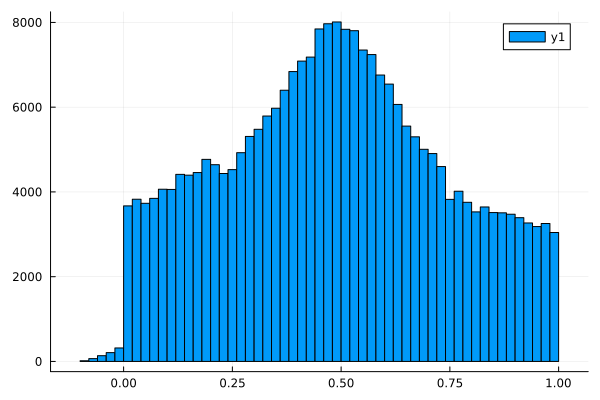

In [29]:
histogram((y_spikes.train.times .- y_spikes.train.offset) .% 1.0)


In [30]:
y_sphase = train_to_phase(y_spikes)

10×100×256 Array{Float64, 3}:
[:, :, 1] =
 -0.08   -0.04         -0.4   -0.22  …  -0.36    0.44   -0.04  0.02  0.12
 -0.14   -0.02         -0.8   -0.3      -0.42  NaN      -0.06  0.04  0.26
 -0.16   -2.93099e-14  -0.88  -0.32     -0.44    0.54   -0.06  0.04  0.34
 -0.18    0.06         -0.9   -0.36     -0.46    0.56   -0.08  0.04  0.4
 -0.18    0.1          -0.92  -0.38     -0.46    0.58   -0.1   0.04  0.42
 -0.18  NaN            -0.94  -0.4   …  -0.42    0.58   -0.12  0.06  0.44
 -0.18  NaN            -0.94  -0.4      -0.42    0.58   -0.12  0.06  0.44
 -0.18  NaN            -0.94  -0.4      -0.42    0.58   -0.12  0.06  0.44
 -0.18  NaN            -0.94  -0.4      -0.42    0.58  NaN     0.04  0.44
 -0.18  NaN            -0.94  -0.42     -0.42    0.58  NaN     0.04  0.44

[:, :, 2] =
 NaN       0.42  -0.06  -0.02  -0.82  …   0.02  0.28  -0.12    0.16    0.44
 NaN     NaN     -0.2   -0.34  -0.68     -0.02  0.28  -0.26  NaN     NaN
 NaN       0.54  -0.3   -0.42  -0.72     -0.04  0.3   -0.

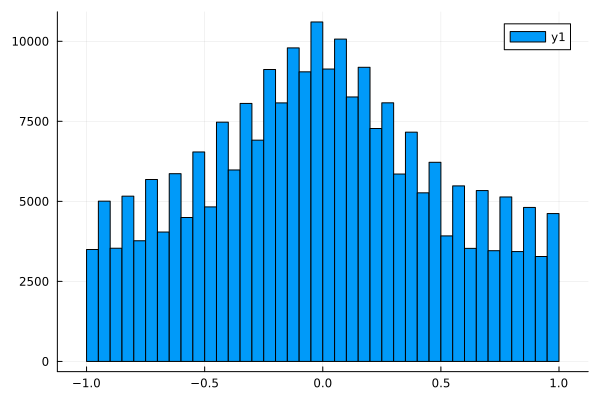

In [31]:
histogram(y_sphase |> vec)

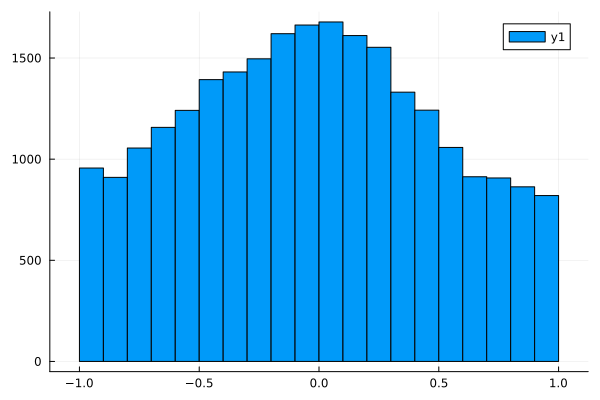

In [32]:
histogram(y_sphase[4,:,:] |> vec, bins=-1.0:0.1:1.0)

In [33]:
scatter(vec(y), vec(y_sphase[4,:,:]))

In [34]:
cv = cycle_correlation(y, y_sphase)

10-element Vector{Float64}:
 0.49330940782441823
 0.74025661468547
 0.8286817320223309
 0.8468500878871554
 0.8512542163215004
 0.8292270635793133
 0.8291627340865666
 0.8293283445851571
 0.8284849004730923
 0.8281503768983296

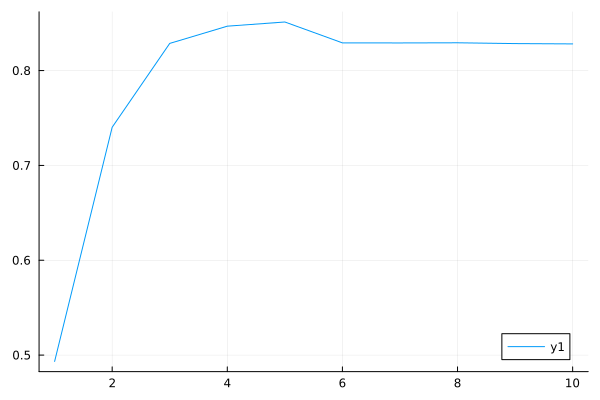

In [35]:
plot(cv)